# 1. Importing libraries

In [1]:
import splitfolders

splitfolders.ratio("PetImages", output="split_petimages",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 24998 files [00:29, 860.46 files/s]


In [1]:
import torch.nn as nn
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [3]:
device

'cuda'

# 2. Data Preprocessing

## Preprocessing data

In [63]:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

# Hyper-parameters
BATCH_SIZE = 128


transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(r'./split_petimages/train', transform=transform_train)
test_dataset = ImageFolder(r'./split_petimages/val', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
tensor([1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1])


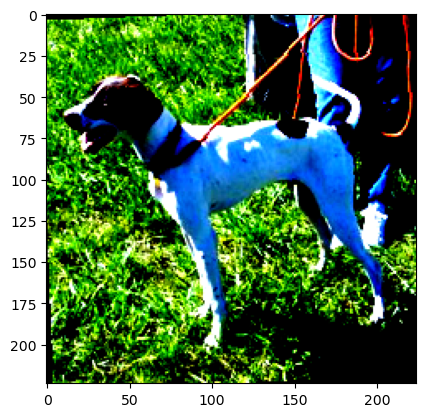

In [64]:
for xb, yb in train_loader:
    print(xb.shape)
    print(xb.shape)
    print(yb)
    break #just once
xb = xb[0]
img = xb.swapaxes(0, 1)
img = img.swapaxes(1, 2)
from matplotlib import pyplot as plt
plt.imshow(img, cmap="gray")

# 3. Building CNN

## Initialising

In [65]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128,512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )

    def forward(self,x):
        x = self.features(x)
        x = self.avg(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 4. Training the CNN

## Training and evaluating

In [66]:
from tqdm import tqdm

In [67]:
num_epochs = 10
learning_rate = 0.001

model = Model().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):

    model.train()

    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')

    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the {total} test images: {100 * correct / total}%')

 64%|██████▎   | 100/157 [00:50<00:35,  1.62it/s]

Epoch [1/10], Step [100/157], Loss: 0.6389


 66%|██████▌   | 104/157 [00:52<00:27,  1.93it/s]C:\Users\12345\anaconda3\envs\tf-gpu\lib\site-packages\PIL\TiffImagePlugin.py:850: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Accuracy of the model on the 5000 test images: 58.6%


 64%|██████▎   | 100/157 [00:51<00:29,  1.90it/s]

Epoch [2/10], Step [100/157], Loss: 0.5868


100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Accuracy of the model on the 5000 test images: 66.14%


 64%|██████▎   | 100/157 [00:48<00:30,  1.88it/s]

Epoch [3/10], Step [100/157], Loss: 0.5961


100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Accuracy of the model on the 5000 test images: 69.4%


 64%|██████▎   | 100/157 [00:48<00:28,  1.99it/s]

Epoch [4/10], Step [100/157], Loss: 0.5649


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Accuracy of the model on the 5000 test images: 71.56%


 64%|██████▎   | 100/157 [00:47<00:28,  2.02it/s]

Epoch [5/10], Step [100/157], Loss: 0.5392


100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Accuracy of the model on the 5000 test images: 68.82%


 64%|██████▎   | 100/157 [00:49<00:29,  1.92it/s]

Epoch [6/10], Step [100/157], Loss: 0.6377


100%|██████████| 40/40 [00:20<00:00,  1.97it/s]


Accuracy of the model on the 5000 test images: 74.14%


 64%|██████▎   | 100/157 [00:50<00:31,  1.81it/s]

Epoch [7/10], Step [100/157], Loss: 0.4863


100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Accuracy of the model on the 5000 test images: 71.24%


 64%|██████▎   | 100/157 [00:51<00:29,  1.90it/s]

Epoch [8/10], Step [100/157], Loss: 0.4897


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Accuracy of the model on the 5000 test images: 72.32%


 64%|██████▎   | 100/157 [00:52<00:34,  1.64it/s]

Epoch [9/10], Step [100/157], Loss: 0.5057


100%|██████████| 40/40 [00:22<00:00,  1.74it/s]


Accuracy of the model on the 5000 test images: 74.56%


 64%|██████▎   | 100/157 [00:58<00:37,  1.53it/s]

Epoch [10/10], Step [100/157], Loss: 0.4454


100%|██████████| 40/40 [00:22<00:00,  1.81it/s]

Accuracy of the model on the 5000 test images: 72.8%


# 5. Single prediction

In [101]:
import numpy as np
from PIL import Image

transform = transforms.ToTensor()

# load your image(s)
img = Image.open('data/single_prediction/cat_or_dog_2.jpg').resize((224,224))

# Transform
img_ready = transform(img).to(device).unsqueeze(0)

# Set model to eval
model.eval()

# Get prediction
output = model(img_ready)
index = output.data.cpu().numpy().argmax()
print(index)
if index == 1:
    prediction = "dog"
else:
    prediction = "cat"

0


Prediction: cat


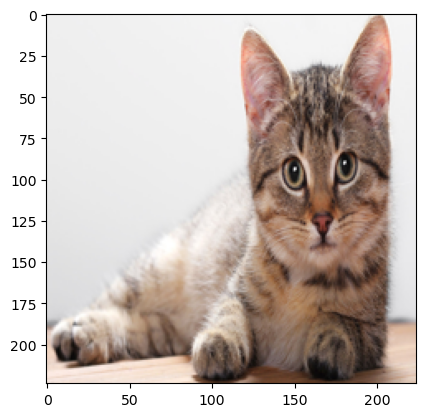

In [102]:
import matplotlib.pyplot as plt

plt.imshow(img)
print(f"Prediction: {prediction}")